## Generating PoTion features out of pose estimation outputs from each video clip. 
## augmenting the generated features by creating shifted and rotated versions of the originals
## saving extracted features as a LMDB database to input to the network
This script contains the functions for pose motion feature representation,
creating training, validation, and test LMDB database to input to the action classification
network

In [56]:
# import required packages and global variables
import sys
import os
import io
import cPickle as pickle
import os.path as osp
import numpy as np
from numpy.random import randint
import math
import matplotlib.pyplot as plt
import cv2 as cv
import glob
from scipy.ndimage.interpolation import shift, rotate
from scipy.ndimage import affine_transform
from random import shuffle
# import extra liraries required for designing the network
import lmdb
import shutil
from caffe2.proto import caffe2_pb2
%matplotlib inline

### Defining global variables

In [57]:
DTYPE = np.float32
height = 1080  # frame height in pixel
width = 1920  # frame width in pixel
fps = 30.0
col_ch = 3
sigma = 2
resize_scale = 0.125
sub_sample =1500
sub_sample_test = 150
crop = False
classes=[
    'Sitting',
    'Sit-to-Stand',
    'Standing',
    'Walking',
    'Stand-to-Sit'
]
keypoints = [
        'nose',
        'left_eye',
        'right_eye',
        'left_ear',
        'right_ear',
        'left_shoulder',
        'right_shoulder',
        'left_elbow',
        'right_elbow',
        'left_wrist',
        'right_wrist',
        'left_hip',
        'right_hip',
        'left_knee',
        'right_knee',
        'left_ankle',
        'right_ankle']

### Defining the required preprocessing functions

In [58]:
def joint_im(im_size, ksize, kernel, keyps=None, joint_name=None, joint_pos=None, kepoint_list=keypoints):
    """
    constructs an pose map image for each body joint by creating a given kernel around the joint location.
    ====== input =======
    im_size: size of the desired pose map
    ksize: size of the kernel
    kernel: desired kernel to be used for the pose map generation
    keyps: location of the key point with respect to the given image size
    joint_name: name of the body joint
    joint_pos: position of the joint with respect to the given image size
    keypoint_list: the list containing the name of the body joints with the order of results in the keyps

    ======= output ========
    joint_im: pose map corresponding the given body joint
    """
    if joint_pos is None:
        if joint_name is not None and keyps is not None:
            joint_pos = keyps[0, :2, kepoint_list.index(joint_name)]
        else:
            print('you have to input either joint position or joint name')
            return

    joint_im = np.zeros(im_size, dtype=DTYPE)
    try:
        # print(joint_pos)
        joint_im[:, int(joint_pos[1] - ksize / 2.0):int(joint_pos[1] + ksize / 2.0),
        int(joint_pos[0] - ksize / 2.0): int(joint_pos[0] + ksize / 2.0)] = kernel
    except(ValueError):
        # print('the location of the joint is very close to the borders')
        pass
    except(OverflowError):
        # print('encounter overflow error because of the infinite value of joint position')
        pass
    return joint_im


def colorize(im, total_fr, fr_no):
    """
    motion representation of the input pose maps from consequent frames based on the color codeing of
    the time proceeding
    ====== input ======
    im: pose map with gray scale intensity ( all the channels have are identical)
    total_fr : total number of frames in the action clip
    fr_no: frame number of the input im in the action clip
    """
    n_ch = im.shape[0]
    im_colorized = np.zeros(im.shape, dtype=DTYPE)
    interval = (1.0 * total_fr) / (n_ch - 1)
    extreme = range(0, total_fr + n_ch - 1, int(interval))
    region = int(math.floor((1.0 * fr_no) / interval))
    # print('region is {}, frame number is:{} and interval is:{}, total frame is:{}'
    #      .format(region, fr_no, interval, total_fr))
    oc_t = np.zeros(n_ch)
    oc_t[region] = (extreme[region + 1] - fr_no) / interval
    oc_t[region + 1] = (fr_no - extreme[region]) / interval
    for i in range(n_ch):
        im_colorized[i, :, :] = im[i, :, :] * oc_t[i]

    return im_colorized  # ,oc_t


def joint_im(im_size, ksize, kernel, keyps=None, joint_name=None, joint_pos=None, kepoint_list=keypoints):
    """
    constructs an pose map image for each body joint by creating a given kernel around the joint location.
    ====== input =======
    im_size: size of the desired pose map
    ksize: size of the kernel
    kernel: desired kernel to be used for the pose map generation
    keyps: location of the key point with respect to the given image size
    joint_name: name of the body joint
    joint_pos: position of the joint with respect to the given image size
    keypoint_list: the list containing the name of the body joints with the order of results in the keyps

    ======= output ========
    joint_im: pose map corresponding the given body joint
    """
    if joint_pos is None:
        if joint_name is not None and keyps is not None:
            joint_pos = keyps[0, :2, kepoint_list.index(joint_name)]
        else:
            print('you have to input either joint position or joint name')
            return

    joint_im = np.zeros(im_size, dtype=DTYPE)
    try:
        # print(joint_pos)
        joint_im[:, int(joint_pos[1] - ksize / 2.0):int(joint_pos[1] + ksize / 2.0),
        int(joint_pos[0] - ksize / 2.0): int(joint_pos[0] + ksize / 2.0)] = kernel
    except(ValueError):
        # print('the location of the joint is very close to the borders')
        pass
    except(OverflowError):
        # print('encounter overflow error because of the infinite value of joint position')
        pass
    return joint_im


def colorize(im, total_fr, fr_no):
    """
    motion representation of the input pose maps from consequent frames based on the color codeing of
    the time proceeding
    ====== input ======
    im: pose map with gray scale intensity ( all the channels have are identical)
    total_fr : total number of frames in the action clip
    fr_no: frame number of the input im in the action clip
    """
    n_ch = im.shape[0]
    im_colorized = np.zeros(im.shape, dtype=DTYPE)
    interval = (1.0 * total_fr) / (n_ch - 1)
    extreme = range(0, total_fr + n_ch - 1, int(interval))
    region = int(math.floor((1.0 * fr_no) / interval))
    # print('region is {}, frame number is:{} and interval is:{}, total frame is:{}'
    #      .format(region, fr_no, interval, total_fr))
    oc_t = np.zeros(n_ch)
    oc_t[region] = (extreme[region + 1] - fr_no) / interval
    oc_t[region + 1] = (fr_no - extreme[region]) / interval
    for i in range(n_ch):
        im_colorized[i, :, :] = im[i, :, :] * oc_t[i]

    return im_colorized  # ,oc_t


def PoTion(in_pose, img_size=(height, width), ch=3, sigma=2, scale=1):
    """
    Recieves a pickle file storing the result of the pose estimation and target tracking.
    creates a Gaussian with the given variance around each joint to create pose maps.
    Then aggregates pose maps in consequent frames to a single image by time dependant color coding.
    ==== input ====
    in_pose: path to the pickle file of the pose estimation results for each action clip
    img_size : size of the original images which the pose estimation is executed on
    col_ch: number of channels for the colorization
    sigma: standard deviation of the Gaussian distrinution around each limb joint
    ==== output ====
    A multi channel image pose evolution representation of the action clip
    """
    # print(in_pose)
    img_size = (int(scale * img_size[0]), int(scale * img_size[1]))
    # print(img_size)
    n_ch = 14 * ch
    eps = 1e-5
    pose_mo = np.zeros((n_ch, img_size[0], img_size[1]), dtype=DTYPE)
    with open(in_pose) as res:
        dets = pickle.load(res)
    all_keyps = dets["target_keyps"]
    all_boxes = dets["target_boxes"]
    # print("key points:{}".format(all_keyps))
    # finding maximum height and width
    #    h = []
    #    w = []
    #    for i in range(len(all_boxes)):
    #        box = scale * all_boxes[i][0]
    #        try:
    #            h.append(box[0, 3] - box[0, 1])
    #            w.append(box[0, 2] - box[0, 0])
    #        except:
    #            pass
    #    h_max = np.amax(np.array(h))
    #    w_max = np.amax(np.array(w))

    ksize = int(6 * sigma)
    if crop:
        h_pad = math.ceil(h_max / 2)
        w_pad = math.ceil(w_max / 2)
    else:
        w_pad = 0
        h_pad = 0
    head_mo = np.zeros((ch, img_size[0] + h_pad, img_size[1] + w_pad), dtype=DTYPE)
    neck_mo = np.zeros((ch, img_size[0] + h_pad, img_size[1] + w_pad), dtype=DTYPE)
    left_shoulder_mo = np.zeros((ch, img_size[0] + h_pad, img_size[1] + w_pad), dtype=DTYPE)
    right_shoulder_mo = np.zeros((ch, img_size[0] + h_pad, img_size[1] + w_pad), dtype=DTYPE)
    left_elbow_mo = np.zeros((ch, img_size[0] + h_pad, img_size[1] + w_pad), dtype=DTYPE)
    right_elbow_mo = np.zeros((ch, img_size[0] + h_pad, img_size[1] + w_pad), dtype=DTYPE)
    left_wrist_mo = np.zeros((ch, img_size[0] + h_pad, img_size[1] + w_pad), dtype=DTYPE)
    right_wrist_mo = np.zeros((ch, img_size[0] + h_pad, img_size[1] + w_pad), dtype=DTYPE)
    left_hip_mo = np.zeros((ch, img_size[0] + h_pad, img_size[1] + w_pad), dtype=DTYPE)
    right_hip_mo = np.zeros((ch, img_size[0] + h_pad, img_size[1] + w_pad), dtype=DTYPE)
    left_knee_mo = np.zeros((ch, img_size[0] + h_pad, img_size[1] + w_pad), dtype=DTYPE)
    right_knee_mo = np.zeros((ch, img_size[0] + h_pad, img_size[1] + w_pad), dtype=DTYPE)
    left_ankle_mo = np.zeros((ch, img_size[0] + h_pad, img_size[1] + w_pad), dtype=DTYPE)
    right_ankle_mo = np.zeros((ch, img_size[0] + h_pad, img_size[1] + w_pad), dtype=DTYPE)

    gauss_ker = cv.getGaussianKernel(ksize=ksize, sigma=sigma)
    gauss_ker = gauss_ker / max(gauss_ker)
    gauss_ker_2d = gauss_ker * gauss_ker.T
    total_fr = len(all_keyps)
    for i in range(0, len(all_keyps), 1):
        keyps = np.array(all_keyps[i])

        if np.prod(keyps.shape) > 0:
            # print(keyps.shape)
            if len(keyps.shape) == 2:
                keyps = np.expand_dims(keyps, axis=0)
            # print(keyps.shape)
            keyps[0, :2, :] = scale * keyps[0, :2, :]
            ######## Head
            high_conf = keyps[0, :2, :5] > 2.3
            head_pos = np.array((keyps[0, :2, :5] * high_conf), dtype=DTYPE)
            # print head_pos
            # print head_pos.shape
            # print high_conf[0,:].shape
            # print np.sum(high_conf[0,:])
            head_pos = np.sum(head_pos, axis=1) / (np.sum(high_conf[0, :])+eps)
            # print head_pos
            head_im = joint_im(im_size=(ch, img_size[0], img_size[1]), ksize=ksize, kernel=gauss_ker_2d,
                               joint_pos=head_pos)
            head_im = colorize(head_im, total_fr, fr_no=i)

            head_mo = head_mo + head_im
            ####### Neck
            neck_pos = np.sum(keyps[0, 0:2, 5:7], axis=1) / 2.0
            # print neck_pos
            neck_im = joint_im(im_size=(ch, img_size[0], img_size[1]), ksize=ksize, kernel=gauss_ker_2d,
                               joint_pos=neck_pos)
            neck_im = colorize(neck_im, total_fr, fr_no=i)
            neck_mo = neck_mo + neck_im
            ###### Left shoulder
            left_shoulder_im = joint_im(im_size=(ch, img_size[0], img_size[1]), ksize=ksize, kernel=gauss_ker_2d,
                                        keyps=keyps, joint_name='left_shoulder')
            left_shoulder_im = colorize(left_shoulder_im, total_fr, fr_no=i)
            left_shoulder_mo = left_shoulder_mo + left_shoulder_im
            ###### Right shoulder
            right_shoulder_im = joint_im(im_size=(ch, img_size[0], img_size[1]), ksize=ksize, kernel=gauss_ker_2d,
                                         keyps=keyps, joint_name='right_shoulder')
            right_shoulder_im = colorize(right_shoulder_im, total_fr, fr_no=i)
            right_shoulder_mo = right_shoulder_mo + right_shoulder_im
            ###### Left elbow
            left_elbow_im = joint_im(im_size=(ch, img_size[0], img_size[1]), ksize=ksize, kernel=gauss_ker_2d,
                                     keyps=keyps, joint_name='left_elbow')
            left_elbow_im = colorize(left_elbow_im, total_fr, fr_no=i)
            left_elbow_mo = left_elbow_mo + left_elbow_im
            ###### Right elbow
            right_elbow_im = joint_im(im_size=(ch, img_size[0], img_size[1]), ksize=ksize, kernel=gauss_ker_2d,
                                      keyps=keyps, joint_name='right_elbow')
            right_elbow_im = colorize(right_elbow_im, total_fr, fr_no=i)
            right_elbow_mo = right_elbow_mo + right_elbow_im
            ###### Left wrist
            left_wrist_im = joint_im(im_size=(ch, img_size[0], img_size[1]), ksize=ksize, kernel=gauss_ker_2d,
                                     keyps=keyps, joint_name='left_wrist')
            left_wrist_im = colorize(left_wrist_im, total_fr, fr_no=i)
            left_wrist_mo = left_wrist_mo + left_wrist_im
            ##### Right wrist
            right_wrist_im = joint_im(im_size=(ch, img_size[0], img_size[1]), ksize=ksize, kernel=gauss_ker_2d,
                                      keyps=keyps, joint_name='right_wrist')
            right_wrist_im = colorize(right_wrist_im, total_fr, fr_no=i)
            right_wrist_mo = right_wrist_mo + right_wrist_im
            ###### Left Hip
            left_hip_im = joint_im(im_size=(ch, img_size[0], img_size[1]), ksize=ksize, kernel=gauss_ker_2d,
                                   keyps=keyps, joint_name='left_hip')
            left_hip_im = colorize(left_hip_im, total_fr, fr_no=i)
            left_hip_mo = left_hip_mo + left_hip_im
            ###### right Hip
            right_hip_im = joint_im(im_size=(ch, img_size[0], img_size[1]), ksize=ksize, kernel=gauss_ker_2d,
                                    keyps=keyps, joint_name='right_hip')
            right_hip_im = colorize(right_hip_im, total_fr, fr_no=i)
            right_hip_mo = right_hip_mo + right_hip_im
            ###### Left knee
            left_knee_im = joint_im(im_size=(ch, img_size[0], img_size[1]), ksize=ksize, kernel=gauss_ker_2d,
                                    keyps=keyps, joint_name='left_knee')
            left_knee_im = colorize(left_knee_im, total_fr, fr_no=i)
            left_knee_mo = left_knee_mo + left_knee_im
            ###### Right knee
            right_knee_im = joint_im(im_size=(ch, img_size[0], img_size[1]), ksize=ksize, kernel=gauss_ker_2d,
                                     keyps=keyps, joint_name='right_knee')
            right_knee_im = colorize(right_knee_im, total_fr, fr_no=i)
            right_knee_mo = right_knee_mo + right_knee_im
            ###### Left ankle
            left_ankle_im = joint_im(im_size=(ch, img_size[0], img_size[1]), ksize=ksize, kernel=gauss_ker_2d,
                                     keyps=keyps, joint_name='left_ankle')
            left_ankle_im = colorize(left_ankle_im, total_fr, fr_no=i)
            left_ankle_mo = left_ankle_mo + left_ankle_im
            ##### Right ankle
            right_ankle_im = joint_im(im_size=(ch, img_size[0], img_size[1]), ksize=ksize, kernel=gauss_ker_2d,
                                      keyps=keyps, joint_name='right_ankle')
            right_ankle_im = colorize(right_ankle_im, total_fr, fr_no=i)
            right_ankle_mo = right_ankle_mo + right_ankle_im

    head_mo = head_mo / (np.amax(head_mo) + eps)
    neck_mo = neck_mo / (np.amax(neck_mo) + eps)
    left_shoulder_mo = left_shoulder_mo / (np.amax(left_shoulder_mo) + eps)
    right_shoulder_mo = right_shoulder_mo / (np.amax(right_shoulder_mo) + eps)
    left_elbow_mo = left_elbow_mo / (np.amax(left_elbow_mo) + eps)
    right_elbow_mo = right_elbow_mo / (np.amax(right_elbow_mo) + eps)
    left_wrist_mo = left_wrist_mo / (np.amax(left_wrist_mo) + eps)
    right_wrist_mo = right_wrist_mo / (np.amax(right_wrist_mo) + eps)
    left_hip_mo = left_hip_mo / (np.amax(left_hip_mo) + eps)
    right_hip_mo = right_hip_mo / (np.amax(right_hip_mo) + eps)
    left_knee_mo = left_knee_mo / (np.amax(left_knee_mo) + eps)
    right_knee_mo = right_knee_mo / (np.amax(right_knee_mo) + eps)
    left_ankle_mo = left_ankle_mo / (np.amax(left_ankle_mo) + eps)
    right_ankle_mo = right_ankle_mo / (np.amax(right_ankle_mo) + eps)
    np.concatenate((head_mo, neck_mo, left_shoulder_mo, right_shoulder_mo, left_elbow_mo, right_elbow_mo,
                    left_wrist_mo, right_wrist_mo, left_hip_mo, right_hip_mo, left_knee_mo, right_knee_mo,
                    left_ankle_mo, right_ankle_mo), axis=0, out=pose_mo)
    output_shape = pose_mo.shape
    max_x_sh = img_size[1]//4
    max_y_sh = img_size[0]//4
    min_x_sh = -1 * max_x_sh
    min_y_sh = -1 * max_y_sh
    shift_x = randint(low=min_x_sh, high=max_x_sh)
    shift_y = randint(low=min_y_sh, high=max_y_sh)
    degree = 180
    pose_mo_shift = shift(pose_mo, shift=[0, shift_y, shift_x])
    pose_mo_flip = rotate(pose_mo, angle=degree, axes=(2,1))
    pose_mo_shiftflip = shift(pose_mo_flip, shift=[0, shift_y, shift_x] )
    if np.sum(pose_mo) <= eps:
        return None
    else:
        return [pose_mo, pose_mo_shift, pose_mo_flip, pose_mo_shiftflip]


### The following is for the visualization of the pose motion feature representation

In [52]:
ch=3
img_size=(height, width)
sigma=3
in_file = '../input/TuftsVideos/Posture/train/Sit-to-Stand/*.pkl'
in_f = '../input/TuftsVideos/Posture/train/Sit-to-Stand/2102_066718_066781.pkl'
temp = glob.glob(in_file)
pose_mo = PoTion(
    temp[10], img_size=(height, width), ch=ch, sigma=sigma, scale=resize_scale)

In [11]:
# this scrip is for representing the time color-coding map for different number of channels
# this will be needed while writing the paper
im = np.random.randn(4, 340, 500)
total_frame = 400
oc_t = np.zeros((4, total_frame))
for fr_no in range(total_frame):
    _,oc_t[:, fr_no] = colorize(im, total_frame, fr_no)

t=np.linspace(start=0, stop=total_frame-1, num=total_frame)
plt.plot(t, oc_t[0,:], t, oc_t[1,:], t, oc_t[2,:], t, oc_t[3,:])
plt.xlim(0, total_frame)
plt.ylim(0, 1.1)
plt.show()

ValueError: too many values to unpack

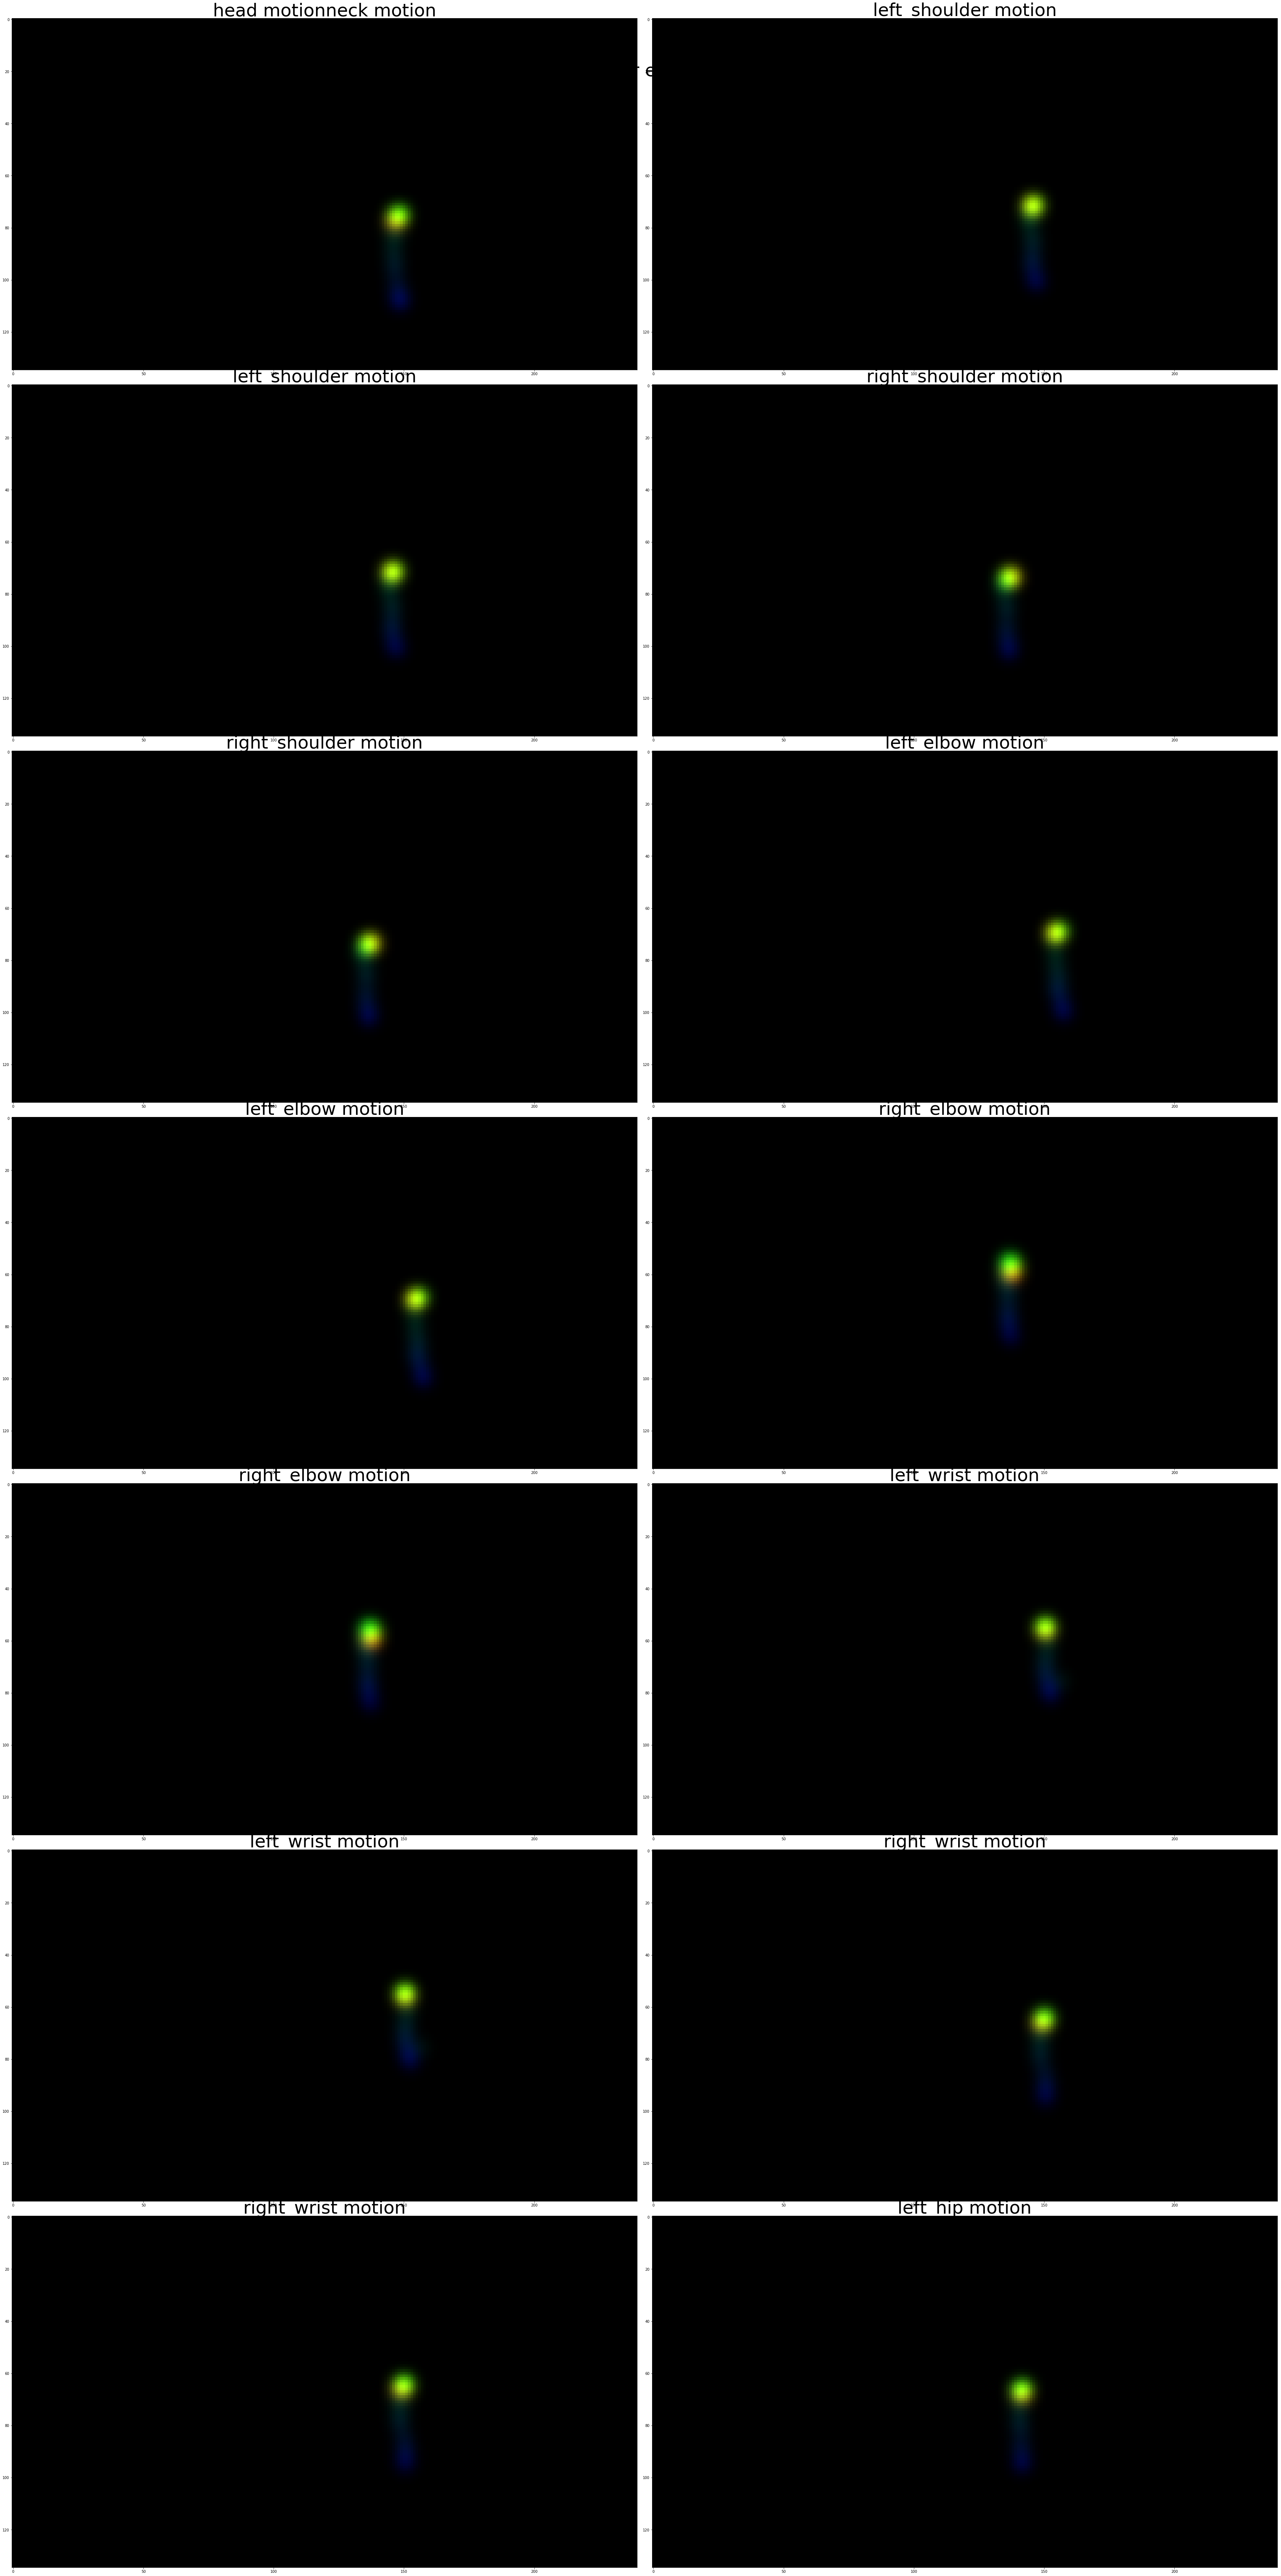

In [55]:
# this script is for the visualization of the pose motion representation
# this will be needed when writing the paper
po_tion_im = pose_mo[2]
titles = [
        'head motion'
        'neck motion',
        'left_shoulder motion',
        'right_shoulder motion',
        'left_elbow motion',
        'right_elbow motion',
        'left_wrist motion',
        'right_wrist motion',
        'left_hip motion',
        'right_hip motion',
        'left_knee motion',
        'right_knee motion',
        'left_ankle motion',
        'right_ankle motion']
ch = 3
nr = 7
nc = 2
fig, axs = plt.subplots(nr, nc, figsize=(50,100))
plt.tight_layout()
fig.suptitle('joint motions for each action clip ', fontsize=50)
for i in range(7):
    for j in range(2):
        axs[i, j].imshow(po_tion_im[(i+j)*ch:(i+j+1)*ch].transpose(1,2,0))
        axs[i, j].set_title(titles[i+j], fontsize=50)
plt.show()

### Dividing the dataset to training, validation and test subsets
We will split the data as follows:
- training: 11604 clips (73%)
- validation: 1590 clips (10%)
- testing: ? clips (17%)

we read all the data in a dictionary along with their labels, after shuffling the list we devide them to three subset according to above proportions.

In [59]:
validation_count = 615
train_data_count = 5200
test_data_count = 645
# Write the script here
# Paths to train and test directories
training_dir_path = osp.join('..', 'input', 'TuftsVideos', 'Posture', 'train')
testing_dir_path = osp.join('..', 'input', 'TuftsVideos', 'Posture', 'test')

# Paths to label files
training_labels_path = osp.join('..', 'input', 'TuftsVideos', 'Posture', 'training_dictionary.txt')
validation_labels_path = osp.join('..', 'input', 'TuftsVideos', 'Posture', 'validation_dictionary.txt')
testing_labels_path = osp.join('..', 'input', 'TuftsVideos', 'Posture', 'testing_dictionary.txt')

# Paths to LMDBs
training_lmdb_path = osp.join('/data', 'BehnazData', 'Results', 'PoseBased_ActionRec', 'training_3_2_111_lmdb')
validation_lmdb_path = osp.join('/data', 'BehnazData', 'Results', 'PoseBased_ActionRec',
                                'validation_3_2_111_lmdb')
testing_lmdb_path = osp.join('/data', 'BehnazData', 'Results', 'PoseBased_ActionRec', 'testing_3_2_111_lmdb')
################### Write our training and validation label files using the training images
if not osp.exists(training_labels_path):
    # Open file handlers
    training_labels_handler = open(training_labels_path, "w")
    validation_labels_handler = open(validation_labels_path, "w")
    # Create training, validation, and testing label files
    i = 0
    clips = []
    for j in range(len(classes)):
        temp = glob.glob(osp.join(training_dir_path, classes[j], '*.pkl'))  # read all training images into array
        print('there are {} clips for the class label {}'.format(len(temp), j))
        shuffle(temp)
        clip_no = len(temp)
        if clip_no <= sub_sample:
            labels = [(temp[k], j) for k in range(clip_no)]
        else:
            labels = [(temp[k], j) for k in range(sub_sample)]

        clips += labels
    shuffle(clips)  # shuffle array
    print(len(clips))
    for clip in clips:
        # Write first 1,320 clip paths, followed by their integer label, to the validation label files
        if i < validation_count:
            validation_labels_handler.write(clip[0] + ' ' + str(clip[1]) + '\n')
        # Write the remaining to the training label files
        else:
            training_labels_handler.write(clip[0] + ' ' + str(clip[1]) + '\n')
        i += 1
    print("Finished writing training and validation label files")
    # Close file handlers
    training_labels_handler.close()
    validation_labels_handler.close()
else:
    print(training_labels_path, "already exists!")

############## Write our testing label files using the testing images
if not osp.exists(testing_labels_path):
    testing_labels_handler = open(testing_labels_path, "w")
    clips = []
    for j in range(len(classes)):
        temp = glob.glob(osp.join(testing_dir_path, classes[j], '*.pkl'))  # read all training images into array
        print('there are {} clips for the class label {}'.format(len(temp), j))
        shuffle(temp)
        clip_no = len(temp)
        if clip_no <= sub_sample_test:
            labels = [(temp[k], j) for k in range(clip_no)]
        else:
            labels = [(temp[k], j) for k in range(sub_sample_test)]

        clips += labels
    shuffle(clips)  # shuffle array
    print(len(clips))
    for clip in clips:
        #
        testing_labels_handler.write(clip[0] + ' ' + str(clip[1]) + '\n')
    print("Finished writing testing label files")
    # close file handlers
    testing_labels_handler.close()
else:
    print(testing_labels_path, "already exists!")

('../input/TuftsVideos/Posture/training_dictionary.txt', 'already exists!')
('../input/TuftsVideos/Posture/testing_dictionary.txt', 'already exists!')


Using the labels to write LMDBs

In [63]:
def write_lmdb(labels_file_path, lmdb_path):
    invalid = []
    valid = []
    labels_handler = open(labels_file_path, "r")
    # Write to lmdb
    print(">>> Write database...")
    LMDB_MAP_SIZE = 1 << 40
    print("LMDB_MAP_SIZE", LMDB_MAP_SIZE)
    env = lmdb.open(lmdb_path, map_size=LMDB_MAP_SIZE)

    with env.begin(write=True) as txn:
        count = 0
        for line in labels_handler.readlines():
            line = line.rstrip()
            clip_path = line.split()[0]
            clip_label = int(line.split()[1])

            # read in image (as multichannel pose motion representation)
            # print(clip_path)
            potion_list = PoTion(clip_path, img_size=(height, width), ch=col_ch, sigma=sigma, scale=resize_scale)

            if potion_list is not None:
                valid.append(line)
                for j in range(len(potion_list)):
                    count = count + 1 
                    potion_data = potion_list[j]
                # Create TensorProtos
                    tensor_protos = caffe2_pb2.TensorProtos()
                    potion_tensor = tensor_protos.protos.add()
                    potion_tensor.dims.extend(potion_data.shape)
                    potion_tensor.data_type = 1
                    flatten_potion = potion_data.reshape(np.prod(potion_data.shape))
                    potion_tensor.float_data.extend(flatten_potion)
                    label_tensor = tensor_protos.protos.add()
                    label_tensor.data_type = 2
                    label_tensor.int32_data.append(clip_label)
                    fileId_tensor = tensor_protos.protos.add()
                    fileId_tensor.data_type=2
                    fileId_tensor.int32_data.append(count)
                    txn.put(
                        '{}'.format(count).encode('ascii'),
                        tensor_protos.SerializeToString()
                    )
                    if ((count % 1000 == 0)):
                        print("Inserted {} rows".format(count))
            else:
                # print('data was invalid, is removed')
                invalid.append(line)

    print("Inserted {} rows".format(count))
    print("\nLMDB saved at " + lmdb_path + "\n\n")
    labels_handler.close()
    return invalid, valid


# Call function to write our LMDBs
if not osp.exists(training_lmdb_path):
    print("Writing training LMDB")
    invalid_path = osp.join(training_lmdb_path, 'invalid_data_list.txt')
    valid_path = osp.join(training_lmdb_path, 'valid_data_list.txt')
    invalid, valid = write_lmdb(training_labels_path, training_lmdb_path)
    handeler0 = open(invalid_path, "w")
    handeler1 = open(valid_path, 'w')
    handeler0.write("\n".join(invalid))
    handeler1.write("\n".join(valid))
    handeler0.close()
    handeler1.close()

else:
    print(training_lmdb_path, "already exists!")
if not osp.exists(validation_lmdb_path):
    print("Writing validation LMDB")
    invalid_path = osp.join(validation_lmdb_path, 'invalid_data_list.txt')
    valid_path = osp.join(validation_lmdb_path, 'valid_data_list.txt')
    invalid, valid = write_lmdb(validation_labels_path, validation_lmdb_path)
    handeler0 = open(invalid_path, "w")
    handeler1 = open(valid_path, 'w')
    handeler0.write("\n".join(invalid))
    handeler1.write("\n".join(valid))
    handeler0.close()
    handeler1.close()


else:
    print(validation_lmdb_path, "already exists!")

if not osp.exists(testing_lmdb_path):
    print("Writing testing LMDB")
    invalid_path = osp.join(testing_lmdb_path, 'invalid_data_list.txt')
    valid_path = osp.join(testing_lmdb_path, 'valid_data_list.txt')
    invalid, valid = write_lmdb(testing_labels_path, testing_lmdb_path)
    handeler0 = open(invalid_path, "w")
    handeler1 = open(valid_path, 'w')
    handeler0.write("\n".join(invalid))
    handeler1.write("\n".join(valid))
    handeler0.close()
    handeler1.close()
else:
    print(testing_lmdb_path, "already exists!")

Writing training LMDB
>>> Write database...
('LMDB_MAP_SIZE', 1099511627776)
Inserted 1000 rows
Inserted 2000 rows
Inserted 3000 rows
Inserted 4000 rows
Inserted 5000 rows
Inserted 6000 rows
Inserted 7000 rows
Inserted 8000 rows
Inserted 9000 rows
Inserted 10000 rows
Inserted 11000 rows
Inserted 12000 rows
Inserted 13000 rows
Inserted 14000 rows
Inserted 15000 rows
Inserted 16000 rows
Inserted 17000 rows
Inserted 18000 rows
Inserted 18796 rows

LMDB saved at /data/BehnazData/Results/PoseBased_ActionRec/training_3_2_111_lmdb


Writing validation LMDB
>>> Write database...
('LMDB_MAP_SIZE', 1099511627776)
Inserted 1000 rows
Inserted 2000 rows
Inserted 2216 rows

LMDB saved at /data/BehnazData/Results/PoseBased_ActionRec/validation_3_2_111_lmdb


Writing testing LMDB
>>> Write database...
('LMDB_MAP_SIZE', 1099511627776)
Inserted 1000 rows
Inserted 2000 rows
Inserted 2504 rows

LMDB saved at /data/BehnazData/Results/PoseBased_ActionRec/testing_3_2_111_lmdb


